# 2. EXPLORACION DEL CORPUS

## 2.1. Imports y settings previos

In [ ]:
#Estas dos librerias hay que subirlas al colab nos la proporciono la profesora
!pip install -r requirements.txt
!pip install utils.py

In [ ]:


import random
import numpy as np
import pandas as pd
from collections import Counter # Exploración
from nltk import ngrams # Exploración
from nltk.probability import FreqDist # Exploración
from stop_words import get_stop_words # Preprocesado
import unicodedata # Preprocesado
import re # Preprocesado
from wordcloud import WordCloud, STOPWORDS


from sklearn.model_selection import train_test_split # Modelado
from sklearn.pipeline import Pipeline # Modelado
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # Modelado
from sklearn.feature_selection import chi2 # Reporte
from sklearn.linear_model import LogisticRegression # Reporte
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve # Reporte

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

## 2.2. Descarga del corpus

In [ ]:
#Nos conectamos a drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/practica_NPL/Software.csv", sep=',')
df.shape


(4000, 12)

In [ ]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,1,True,"04 26, 2014",A3I9A3HC4Q07KA,B000096L6Z,NaN,Mmm,useless . io could not get it on any computer....,terrible,1398470400,NaN,NaN
1,1,False,"02 19, 2008",A3LBY83F9S6LJL,B000W3RSGE,"{'Format:': ' Box', 'Platform:': ' PC/Mac Disc'}",J. Harney,I labored for many hours over my Turbo tax ret...,Useless,1203379200,NaN,NaN
2,1,True,"08 24, 2016",AO7UI8VR753UV,B00597EEIS,{'Platform:': ' PC Download'},carmen ochoa,I had to buy another software because this one...,I had to buy another software because this one...,1471996800,NaN,NaN
3,1,True,"02 22, 2015",A10HGVMF633JPR,B00PG8FWS6,NaN,SteveM,Junk. Wull not install after being downloaded....,Junk. Wont install from download,1424563200,NaN,NaN
4,1,False,"05 21, 2003",A19JU20V8YD8BS,B000069IFH,NaN,Kevin Klasmeier,I have been with Quicken since 3.0. I have lov...,Trust me: Don't buy it! Don't install it! Dont...,1053475200,26.0,NaN


In [ ]:
#eliminamos NA
df.dropna(subset=['reviewText'], inplace=True)

## 2.3. Creacion de las etiquetas

Vamos a definir:

> -1 y 2 estrellas-> sentimiento negativo lo representaremos por 0

> -4 y 5 estrellas-> sentimineto positivo lo representaremos por 1



In [ ]:
df["labels"] = None

df.loc[df["overall"] < 3,'labels'] = 0

df.loc[df["overall"] > 3,'labels'] = 1


<Axes: >

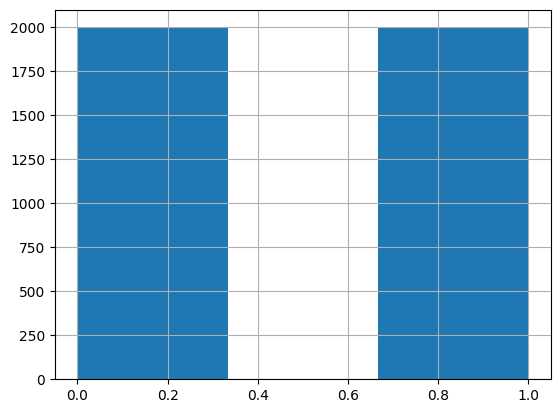

In [ ]:
#comprobamos que sigan balanceadas las etiquetas
df['labels'].hist(bins=3)

## 2.4. Dividimos el data set entre entrenamiento, test y validacion

In [ ]:
# dividimos datos entre entranamiento y test
data_train, data_test, labels_train, labels_test = train_test_split(df['reviewText'], df['labels'], test_size=0.15, shuffle=True, random_state=0)


In [ ]:
# pasamos a csv
data_train.to_csv('data_train.csv', index=False)
data_test.to_csv('data_test.csv', index=False)

labels_train.to_csv('labels_train.csv', index=False)
labels_test.to_csv('labels_test.csv', index=False)

In [ ]:
!cp data_train.csv data_test.csv /content/drive/MyDrive/practica_NPL/
!cp labels_train.csv labels_test.csv /content/drive/MyDrive/practica_NPL/

## 2.5. Analizado de datos previos

In [ ]:
data_train.head()

3369                      one of the best programs to use
2521    Do yourself a Favor, and Upgrade from Windows ...
3825    I highly recommend toast I haven't I'm on my  mac
3491    This simple little connection and software rep...
1073    Slapping a smartphone interface on a workstati...
Name: reviewText, dtype: object

In [ ]:
labels_train.head()

3369    1
2521    1
3825    1
3491    1
1073    0
Name: labels, dtype: object

In [ ]:
#este bucle es para comprobar que lo hemos realizado bien
for index in labels_train.index:
    label = labels_train.loc[index]
    if index == 3369:
      print("Index:", index)
      print("Label:", label)
      print("-----")
    if index == 1073:
      print("Index:", index)
      print("Label:", label)
      print("-----")

Index: 3369
Label: 1
-----
Index: 1073
Label: 0
-----


Vemos que las etiquetas siguen balanceadas:

<Axes: >

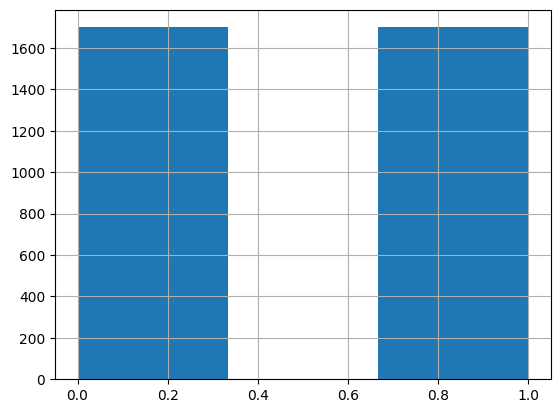

In [ ]:
labels_train.hist(bins=3)

Observamos que hay una pequena diferencia pero funcionalmente podemos decir que son las mismas.

In [ ]:
splitted_reviews = data_train.str.lower().str.split()

In [ ]:
words = splitted_reviews.apply(pd.Series).stack().reset_index(drop = True)

<ipython-input-55-dd67bd68fda7>:1: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  words = splitted_reviews.apply(pd.Series).stack().reset_index(drop = True)


In [ ]:
vocabulary_ = Counter(words)

Número de tokens que componen el vocabulario

In [ ]:
len(vocabulary_)

24197

## 2.6. N-grams mas frecuentes

Realizamos el cálculo de los 2-gramas y 3-grams directamente de la Series de pandas con todas las palabras. Al estar interesados únicamente en los más frecuentes no habrá problemas al combinar el último token de una review con el token inicial de la siguiente. Esto nos permite agilizar el cómputo en esta etapa previa de exploración.(este texto esta sacado de las clases)

In [ ]:
bigrams_ = ngrams(words, 2)
trigrams_ = ngrams(words, 3)

In [ ]:
bigrams_freq_ = FreqDist(bigrams_)
trigrams_freq_ = FreqDist(trigrams_)

In [ ]:
bigrams_freq_.most_common(10)

[(('i', 'have'), 974),
 (('of', 'the'), 909),
 (('in', 'the'), 672),
 (('it', 'is'), 594),
 (('if', 'you'), 588),
 (('on', 'the'), 538),
 (('is', 'a'), 510),
 (('with', 'the'), 492),
 (('i', 'was'), 486),
 (('to', 'the'), 484)]

In [ ]:
trigrams_freq_.most_common(10)

[(('i', 'have', 'been'), 132),
 (('i', 'had', 'to'), 125),
 (('a', 'lot', 'of'), 123),
 (('if', 'you', 'are'), 109),
 (('this', 'is', 'a'), 107),
 (('you', 'have', 'to'), 107),
 (('i', 'have', 'used'), 99),
 (('i', 'have', 'to'), 94),
 (('you', 'want', 'to'), 82),
 (('there', 'is', 'no'), 80)]

Como se observa hay muchas palabras que no aportan nada por lo que debemos de aplicar stopwords y asi evitamos introducir ruido inecesario al modelo.

In [ ]:
sw = get_stop_words (language = 'en')

new_text = [word for word in words if word not in sw ]
print(new_text)

['one', 'best', 'programs', 'use', 'favor,', 'upgrade', 'windows', '2000.', 'install', '"microsoft', 'office', 'xp', 'professional', 'upgrade,', 'microsoft,"', 'watch', '98%', 'computer', 'woes', 'vanish', 'eyes', '!', 'updates,', 'watch', 'remaining', '2%', 'disappear,', 'without', 'trace.', 'format', 'c:,', 'installed', 'windows', '2000,', 'upgraded', 'xp', 'professional', '&', 'pc', 'running', 'smooth.', 'internet', 'runs', 'smoothly', 'ever', 'seen,', 'before.', 'package', 'comes', 'firewall.', 'games', 'run', 'very,', 'smoothly.', 'computer', 'quiet,', 'barely', 'realize', 'even', 'online.', 'hard', 'time', 'getting', 'standard', 'software', 'run', 'windows', 'me,', 'xp', 'makes', 'everything', 'easy,', 'makes', 'joy', 'work', 'pc.', 'headaches.', 'searching', 'patches', 'internet.', 'package', 'all.', 'work', 'troubleshooting', 'day.', 'now,', 'come', 'home', 'work', 'pc,', 'well.', 'xp', 'answer', 'pc', 'problems.', 'software', 'will', 'pay', 'itself,', 'within', 'weeks', '(or',

In [ ]:
bigrams_ = ngrams(new_text, 2)
trigrams_ = ngrams(new_text, 3)

In [ ]:
bigrams_freq_ = FreqDist(bigrams_)
trigrams_freq_ = FreqDist(trigrams_)

In [ ]:
bigrams_freq_.most_common(10)

[(('turbo', 'tax'), 103),
 (('windows', '7'), 101),
 (('h&r', 'block'), 80),
 (('tech', 'support'), 76),
 (('easy', 'use'), 72),
 (('even', 'though'), 65),
 (('customer', 'service'), 63),
 (('windows', '8'), 62),
 (('windows', 'xp'), 48),
 (('easy', 'use.'), 47)]

In [ ]:
trigrams_freq_.most_common(10)

[(('used', 'turbo', 'tax'), 14),
 (('h&r', 'block', 'tax'), 14),
 (('using', 'turbo', 'tax'), 13),
 (('mac', 'os', 'x'), 12),
 (('will', 'never', 'buy'), 11),
 (('.', '.', '.'), 10),
 (('family', 'tree', 'maker'), 9),
 (('will', 'continue', 'use'), 9),
 (('using', 'quicken', 'since'), 9),
 (('home', '&', 'student'), 9)]

Ahora si tienen mas sentido los bigrams y trigramas, por ejemplo es muy usual en las review de software decir que te funciona bien en tal version de windows o decir que te devuelvan el dinero

## 2.7. Wordcloud

Vamos a realizar el wordcloud tanto para sentimientos positivos como negativos aplicando previamente un stopword.

In [ ]:

positive_review = ""
negative_review = ""

for index in labels_train.index:
    label = labels_train.loc[index]
    review = data_train.loc[index]

    if label == 1:
      positive_review += str(review) + " "
    if label == 0:
      negative_review += str(review) + " "


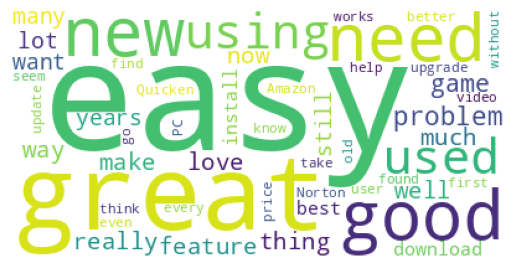

In [ ]:

# Inicializamos el wordcloud
wc = WordCloud(background_color='white', max_words=50,
        # Actualizamos las stopwords para excluir palabras comunes del tema
        stopwords = STOPWORDS.update(['year','file','one','time','computer','work','will','product','program','version','use','software','Windows','Mac']))

plt.imshow(wc.generate(positive_review))
plt.axis('off')
plt.show()

Observamos que palabras como easy o great tienen un gran peso en las review positivas, lo cual tiene sentido ya que un software que sea de facil utilizacion sera muy bien valorado por los usuarios

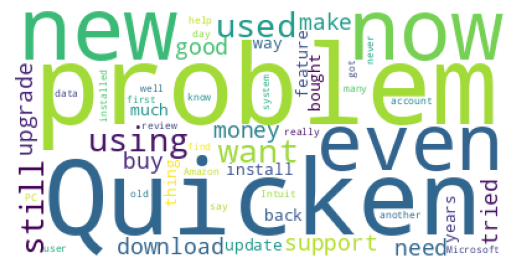

In [ ]:

from wordcloud import WordCloud, STOPWORDS
# Inicializamos el wordcloud
wc = WordCloud(background_color='white', max_words=50,
        # Actualizamos las stopwords para excluir palabras comunes del tema
        stopwords = STOPWORDS.update(['year','file','one','time','computer','work','will','product','program','version','use','software','Windows','Mac']))

plt.imshow(wc.generate(negative_review))
plt.axis('off')
plt.show()

Observamos que palabras como problem estan incluidas en las review negativas lo cual tiene sentido, ya que si un usuario ha tenido un problema con el software lo valorara negativamente